In [ ]:
%%shell
wget -O DETRAC-train-data.zip http://detrac-db.rit.albany.edu/Data/DETRAC-train-data.zip
wget -O DETRAC-test-data.zip http://detrac-db.rit.albany.edu/Data/DETRAC-test-data.zip
wget -O DETRAC-Train-Annotations-XML.zip http://detrac-db.rit.albany.edu/Data/DETRAC-Train-Annotations-XML.zip
wget -O DETRAC-Test-Annotations-XML.zip http://detrac-db.rit.albany.edu/Data/DETRAC-Test-Annotations-XML.zip
mkdir data/
unzip -q DETRAC-train-data.zip -d data/
unzip -q DETRAC-test-data.zip -d data/
unzip -q DETRAC-Train-Annotations-XML.zip -d data/
unzip -q DETRAC-Test-Annotations-XML.zip -d data/

In [ ]:
from types import FrameType
import xml.etree.ElementTree as ET

import os

class_mapping = {
    'car': 0,
    'van': 1,
    'bus': 2,
    'other':3
}

def parse_xml(xml_file):
  image_width=960
  image_height = 540
  tree = ET.parse(xml_file)
  root = tree.getroot()
  frames = {}
  for frame in root.findall('.//frame'):
    frame_number = int(frame.get('num'))
    boxes=[]
    for target in frame.findall('.//target_list/target'):
        vehicle_type = target.find('attribute').get('vehicle_type')
        class_id = class_mapping.get(vehicle_type, -1)
        if class_id == -1:
            continue
        box = target.find('box')
        left = float(box.get('left'))
        top = float(box.get('top'))
        width = float(box.get('width'))
        height = float(box.get('height'))

        x_center = (left + (left + width)) / 2.0
        y_center = (top + (top + height)) / 2.0

        boxes.append((class_id, x_center/image_width, y_center/image_height, width / image_width, height / image_height))
    frames[frame_number]=boxes
  return frames

In [ ]:
def save_yolo_annotations(input_folder,output_folder):
  os.makedirs(output_folder,exist_ok=True)
  sorted_xml_files = sorted(os.listdir(input_folder))
  for xml_file in sorted_xml_files:
    folder_name = os.path.splitext(xml_file)[0]
    frames = parse_xml(os.path.join(input_folder,xml_file))
    for frame_number, targets_info in frames.items():
      output_file = os.path.join(output_folder,f'{folder_name}_img{frame_number:05d}.txt')
      os.makedirs(os.path.dirname(output_file), exist_ok=True)
      with open(output_file, 'w') as f:
          for target_info in targets_info:
              target_id, x_center, y_center, width, height = target_info
              f.write(f"{target_id} {x_center} {y_center} {width} {height}\n")

data_folders = [('train', 'DETRAC-Train-Annotations-XML'), ('val', 'DETRAC-Test-Annotations-XML')]

for output_folder_name, xml_folder_name in data_folders:
  xml_file = '/content/data/{}/'.format(xml_folder_name)
  output_folder = '/content/{}/labels/'.format(output_folder_name)
  save_yolo_annotations(xml_file, output_folder)


In [ ]:
import cv2
import numpy as np
def mask(image, list_of_lists):
    result= 0
    if list_of_lists is not None:
      for x in list_of_lists:
          c1, c2 = (int(float(x[0])), int(float(x[1]))), (int(float(x[2])), int(float(x[3])))
          mask = np.ones(image.shape[:2], dtype='uint8')
          cv2.rectangle(mask, c1, c2, 0, thickness=-1, lineType=cv2.LINE_AA)
          image = cv2.bitwise_and(image, image, mask=mask)
    return image

In [ ]:
def histogram_equalizer(image):
  image = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  equal = cv2.equalizeHist(image)
  return equal

In [ ]:
#masking ignored regions in images

import cv2
import shutil
import os
import xml.etree.ElementTree as ET

labels_paths = ["/content/data/DETRAC-Train-Annotations-XML/", "/content/data/DETRAC-Test-Annotations-XML/"]
image_input_paths = ["/content/data/Insight-MVT_Annotation_Train/", "/content/data/Insight-MVT_Annotation_Test/"]
image_output_paths = ['/content/train/images', '/content/val/images/']

for folder in image_output_paths:
    os.makedirs(folder, exist_ok=True)

for labels_path, images_path in zip(labels_paths, image_input_paths):
    sorted_labels_folder = sorted(os.listdir(labels_path))
    sorted_images_folder = sorted(os.listdir(images_path))

    labels_and_images = zip(sorted_labels_folder, sorted_images_folder)

    for label_folder, folder in labels_and_images:
        tree = ET.parse(os.path.join(labels_path, label_folder))
        root = tree.getroot()
        ignored_region_element = root.find(".//ignored_region")

        if ignored_region_element is not None:
            ignored_boxes = ignored_region_element.findall(".//box")
            ignored_attributes = [[box.get('left'), box.get('top'), box.get('width'), box.get('height')] for box in ignored_boxes]

            for image in sorted(os.listdir(os.path.join(images_path, folder))):
                input_image_path = os.path.join(images_path, folder, image)
                output_image_path = os.path.join(image_output_paths[0], f"{folder}_{image}")
                img = cv2.imread(input_image_path)
                img = mask(img, ignored_attributes)
                cv2.imwrite(output_image_path, img)


In [ ]:
#deleting un-annotated frames
import os

folders = ['train','val']
for folder in folders:
  images_folder = '/content/{}/images'.format(folder)
  labels_folder = '/content/{}/labels'.format(folder)
  image_files = os.listdir(images_folder)
  label_files = os.listdir(labels_folder)
  label_image_names = {os.path.splitext(label)[0] for label in label_files}
  images_to_delete = [image for image in image_files if os.path.splitext(image)[0] not in label_image_names]

  for image in images_to_delete:
      image_path = os.path.join(images_folder, image)
      os.remove(image_path)
      print(f"Deleted: {image_path}")


In [ ]:
print(len(os.listdir("/content/train/labels")))
print(len(os.listdir("/content/train/images")))
print(len(os.listdir("/content/val/labels")))


82085
82085
56167


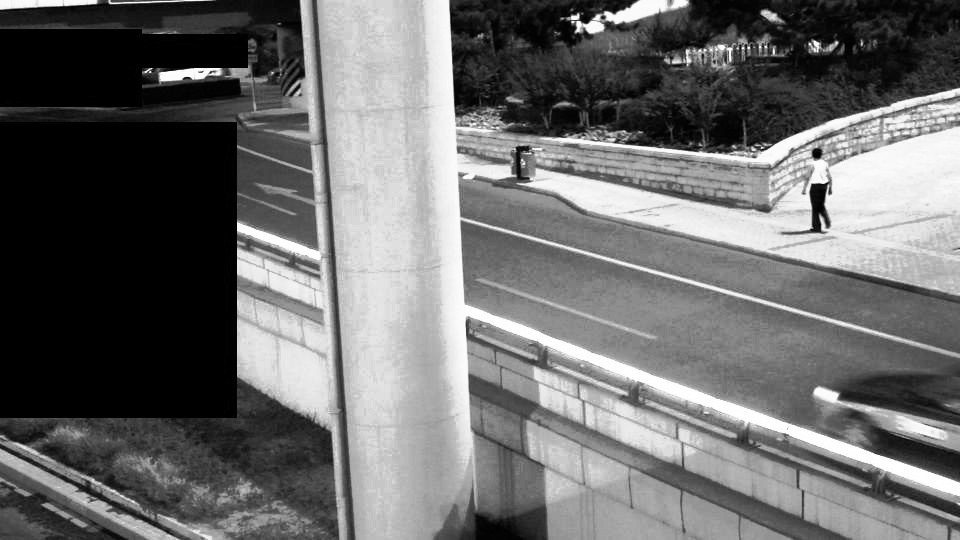

In [ ]:
from google.colab.patches import cv2_imshow
img = "/content/train/images/MVI_40991_img00340.jpg"
img = cv2.imread(img)
cv2_imshow(img)

In [ ]:
folder = "/content/train/images/"
images_path = sorted(os.listdir("/content/train/images"))
for image_path in images_path:
  real_path = os.path.join(folder,image_path)
  img = histogram_equalizer(real_path)
  cv2.imwrite(real_path,img)
  print(image_path)

In [ ]:
!pip install ultralytics
import ultralytics
from ultralytics import YOLO

In [ ]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
model = YOLO('/content/runs/detect/train/weights/last.pt').to(device)

results = model.train(data='data.yaml', epochs=5, imgsz=640,device = 0,batch = 64,save = True)

Ultralytics YOLOv8.0.226 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/content/runs/detect/train/weights/last.pt, data=data.yaml, epochs=5, patience=50, batch=64, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, f

train: Scanning /content/train/labels.cache... 82085 images, 84 backgrounds, 0 corrupt: 100%|██████████| 82085/82085 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/val/labels.cache... 56167 images, 0 backgrounds, 0 corrupt: 100%|██████████| 56167/56167 [00:00<?, ?it/s]


Plotting labels to runs/detect/train4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train4
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      14.1G     0.7521     0.4581     0.8858        475        640: 100%|██████████| 1283/1283 [13:35<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 439/439 [09:41<00:00,  1.33s/it]


                   all      56167     658859      0.686      0.462      0.517      0.374

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      10.6G     0.7699     0.4746       0.89        415        640: 100%|██████████| 1283/1283 [14:11<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 439/439 [09:37<00:00,  1.32s/it]


                   all      56167     658859      0.722      0.502       0.56      0.401

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      12.7G     0.7745     0.4784     0.8914        447        640: 100%|██████████| 1283/1283 [14:11<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 439/439 [09:26<00:00,  1.29s/it]


                   all      56167     658859      0.722       0.49      0.542      0.391

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      11.4G     0.7566     0.4612     0.8864        451        640: 100%|██████████| 1283/1283 [14:11<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 439/439 [09:34<00:00,  1.31s/it]


                   all      56167     658859      0.737      0.488      0.547      0.408

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      11.7G     0.7485     0.4527     0.8837        462        640: 100%|██████████| 1283/1283 [14:10<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 439/439 [09:10<00:00,  1.25s/it]


                   all      56167     658859      0.711      0.487      0.547      0.404

5 epochs completed in 2.712 hours.
Optimizer stripped from runs/detect/train4/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train4/weights/best.pt, 6.2MB

Validating runs/detect/train4/weights/best.pt...
Ultralytics YOLOv8.0.226 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3006428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 439/439 [09:21<00:00,  1.28s/it]


                   all      56167     658859      0.738      0.488      0.548      0.408
                   car      56167     548555      0.836      0.584      0.652       0.47
                   van      56167      38519      0.614      0.358      0.383        0.3
                   bus      56167      71785      0.763      0.522      0.608      0.453
Speed: 0.1ms preprocess, 1.2ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/train4
